Portfolio Audrey Hohmann, geospatial data scientist freelance

This notebook aims to develop a predictive model for wildfire hazard score estimation at the commune level.

# Import libraries and Functions 

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', False)
pd.set_option('display.max_colwidth', 100)

In [3]:
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn import linear_model, ensemble, tree
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

# Import data

In [4]:
clc_legend = pd.read_csv('./data/clc_legend.csv')

In [5]:
com_wildfires = gpd.read_file("data/df_feat_target.geojson")

In [6]:
com_wildfires.shape

(827, 69)

In [7]:
list_col_gdf = com_wildfires.columns

In [8]:
print(list_col_gdf)

Index(['ID', 'NOM', 'NOM_M', 'INSEE_COM', 'STATUT', 'POPULATION', 'INSEE_CAN',
       'INSEE_ARR', 'INSEE_DEP', 'INSEE_REG', 'SIREN_EPCI', 'Code INSEE',
       'Wildfires_count', 'Sum_Surface_tot', 'Sum_Surface_burnforest',
       'Sum_Surface_otherburnforest', 'wildfire_bin', 'area_sqm', 'area_sqkm',
       'MNT', 'slope', 'aspect', 'Class_sum', 'Class_111', 'Class_331',
       'Class_112', 'Class_211', 'Class_131', 'Class_132', 'Class_231',
       'Class_313', 'Class_511', 'Class_512', 'Class_311', 'Class_312',
       'Class_411', 'Class_141', 'Class_122', 'Class_221', 'Class_243',
       'Class_222', 'Class_142', 'Class_121', 'Class_242', 'Class_324',
       'Class_124', 'Class_322', 'Class_sum_percentage', 'CODGEO', 'P21_POP',
       'P21_LOG', 'P21_LOGVAC', 'P21_OCCLOG', 'P21_density',
       'Bac ou liaison maritime', 'Bretelle', 'Chemin', 'Escalier',
       'Rond-point', 'Route empierrée', 'Route à 1 chaussée',
       'Route à 2 chaussées', 'Sentier', 'Type autoroutier', 'freq_r

In [9]:
cols = [col for col in list_col_gdf if col.startswith('Class_') and col not in ['Class_sum', 'Class_sum_percentage']]

In [10]:
cols.extend(['MNT', 'slope',
       'aspect','P21_POP', 'P21_OCCLOG', 'P21_density',
       'Chemin','Route empierrée',
       'Route à 1 chaussée', 'Route à 2 chaussées', 'Sentier',
       'Type autoroutier'])

In [112]:
#cols.remove('slope')

# Model prediction

## Binary target

The target by communes

In [10]:
target = 'wildfire_bin'

In [11]:
df_ml = com_wildfires[cols + [target]]

In [12]:
df_ml.shape

(877, 41)

In [13]:
X = df_ml[cols]
y = df_ml[target]

In [14]:
Counter(y)

Counter({0: 614, 1: 263})

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [18]:
print(f"Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape} ")
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape} ")

Nous avons X_train de forme (701, 40) et y_train de forme (701,) 
Nous avons X_test de forme (176, 40) et y_test de forme (176,) 


In [19]:
y_train.value_counts(normalize=True)

wildfire_bin
0    0.699001
1    0.300999
Name: proportion, dtype: float64

In [20]:
scaler = StandardScaler()
std_scaler = scaler.fit(X) 
X_std = std_scaler.transform(X)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

### Model statements

In [21]:
reglog_balanced = linear_model.LogisticRegression(class_weight='balanced', random_state=42)

In [22]:
reglog = linear_model.LogisticRegression(random_state=42)

In [23]:
rfc_clf = ensemble.RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1, max_depth=10) #, class_weight="balanced")

### Training models

In [ ]:
reglog_balanced.fit(X_train_std, y_train)

In [ ]:
reglog.fit(X_train_std, y_train)

In [ ]:
y_pred_reglog = reglog.predict(X_test_std)

In [ ]:
rfc_clf.fit(X_train_std, y_train)

In [ ]:
def calculer_vraie_profondeur(arbre):
    def profondeur_recursive(noeud, profondeur_courante):
        if arbre.tree_.feature[noeud] == -2:  # C'est une feuille
            return profondeur_courante
        gauche = arbre.tree_.children_left[noeud]
        droite = arbre.tree_.children_right[noeud]
        return max(profondeur_recursive(gauche, profondeur_courante + 1),
                   profondeur_recursive(droite, profondeur_courante + 1))

    return profondeur_recursive(0, 0)

In [ ]:
tree_depths = []
for tree in rfc_clf.estimators_:
    tree_depths.append(calculer_vraie_profondeur(tree))

print(np.mean(tree_depths))
print(np.max(tree_depths))
print(np.min(tree_depths))

In [ ]:
y_pred_rfc_clf = rfc_clf.predict(X_test_std)

### Model evaluation

In [24]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred = model.fit(X_train, y_train).predict(X_test)
    y_prob = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    
    # Precision, Recall, F1 Score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC Curve and AUC Score
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    print(f'ROC AUC Score: {roc_auc:.2f}')
    
    # Classification Report
    report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
    print(report)

#### unbalanced data

Accuracy: 0.81
Precision: 0.74
Recall: 0.56
F1 Score: 0.64


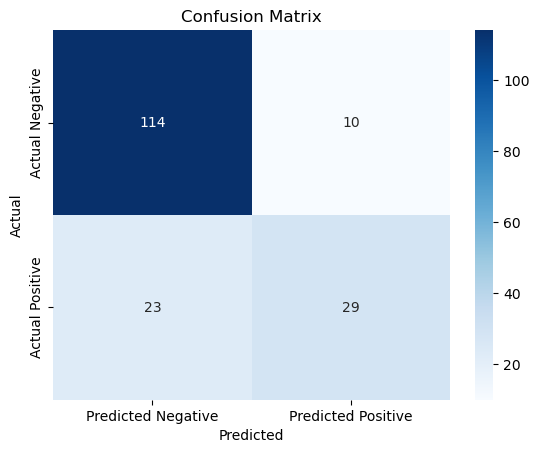

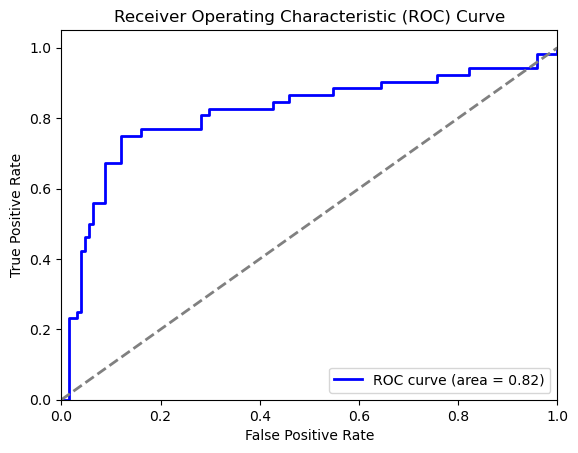

ROC AUC Score: 0.82
              precision    recall  f1-score   support

     Class 0       0.83      0.92      0.87       124
     Class 1       0.74      0.56      0.64        52

    accuracy                           0.81       176
   macro avg       0.79      0.74      0.76       176
weighted avg       0.81      0.81      0.80       176



In [27]:
evaluate_model(reglog, X_train_std, y_train, X_test_std, y_test)

Precision and recall are more useful for my unbalanced data. The precision metric indicates that there are fewer false positives, meaning that fewer communes are incorrectly indicated as being at risk of wildfires.

#### balanced data

Accuracy: 0.83
Precision: 0.70
Recall: 0.75
F1 Score: 0.72


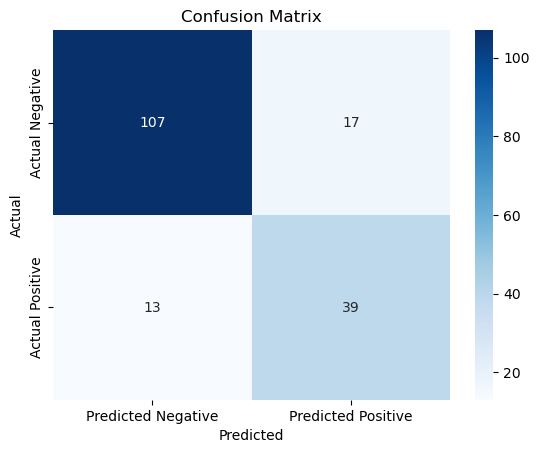

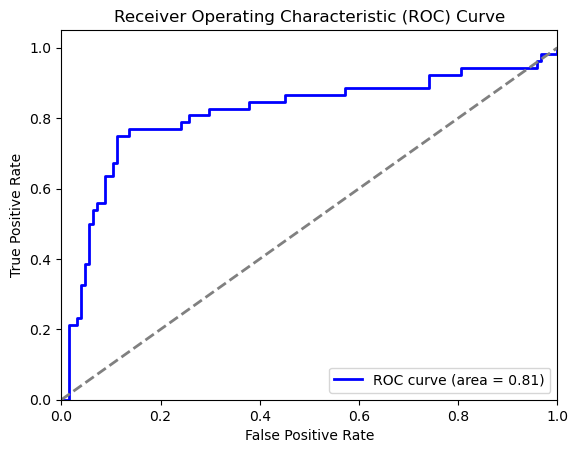

ROC AUC Score: 0.81
              precision    recall  f1-score   support

     Class 0       0.89      0.86      0.88       124
     Class 1       0.70      0.75      0.72        52

    accuracy                           0.83       176
   macro avg       0.79      0.81      0.80       176
weighted avg       0.83      0.83      0.83       176



In [28]:
evaluate_model(reglog_balanced, X_train_std, y_train, X_test_std, y_test)

Accuracy: 0.82
Precision: 0.82
Recall: 0.52
F1 Score: 0.64


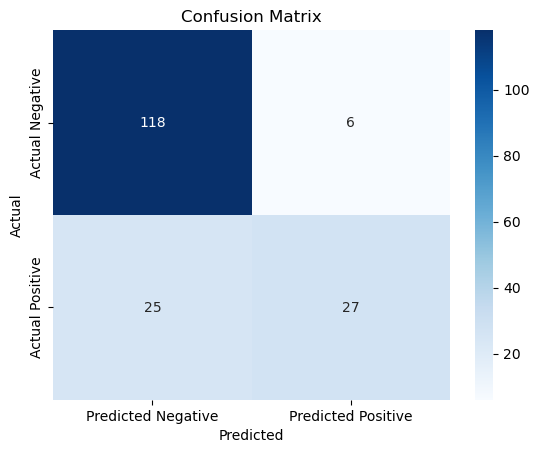

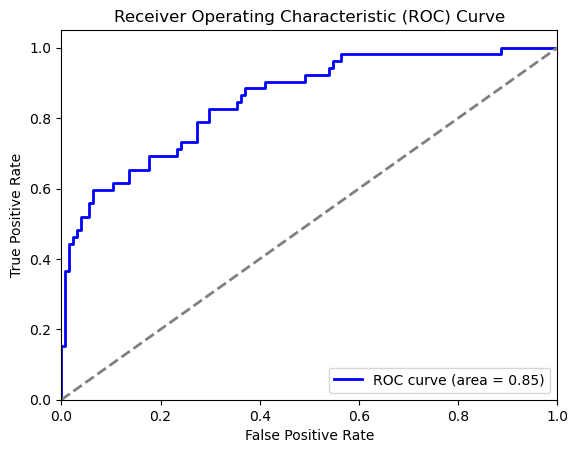

ROC AUC Score: 0.85
              precision    recall  f1-score   support

     Class 0       0.83      0.95      0.88       124
     Class 1       0.82      0.52      0.64        52

    accuracy                           0.82       176
   macro avg       0.82      0.74      0.76       176
weighted avg       0.82      0.82      0.81       176



In [29]:
evaluate_model(rfc_clf, X_train_std, y_train, X_test_std, y_test)

#### cross validation with stratified kfold by default

In [30]:
def scores(clf, ncv, X, y):
    scorer_mapping = {
        'AUC' : 'roc_auc',
        'Precision' : 'precision',
        'Recall' : 'recall',
        'Accuracy': 'accuracy',
        'F1 Score': 'f1',
    }
    

    scores_estimator = cross_validate(clf, X, y, scoring=scorer_mapping, cv=ncv)
    
   
    for score_name in scorer_mapping.keys():
           
        score_mean = scores_estimator['test_' + score_name].mean().round(4)
        score_std = scores_estimator['test_' + score_name].std().round(4)

        print(f"Avec le modèle {clf.__class__.__name__} en validation croisée, {score_name} moyen est de {score_mean}, avec un écart-type de {score_std}")

In [31]:
%%time
scores(reglog, 10, X_train_std, y_train)

Avec le modèle LogisticRegression en validation croisée, AUC moyen est de 0.7962, avec un écart-type de 0.066
Avec le modèle LogisticRegression en validation croisée, Precision moyen est de 0.673, avec un écart-type de 0.1226
Avec le modèle LogisticRegression en validation croisée, Recall moyen est de 0.4645, avec un écart-type de 0.1082
Avec le modèle LogisticRegression en validation croisée, Accuracy moyen est de 0.766, avec un écart-type de 0.0417
Avec le modèle LogisticRegression en validation croisée, F1 Score moyen est de 0.54, avec un écart-type de 0.093
CPU times: user 1.33 s, sys: 220 ms, total: 1.55 s
Wall time: 257 ms


In [32]:
%%time
scores(rfc_clf, 10, X_train_std, y_train)

Avec le modèle RandomForestClassifier en validation croisée, AUC moyen est de 0.7782, avec un écart-type de 0.0633
Avec le modèle RandomForestClassifier en validation croisée, Precision moyen est de 0.7459, avec un écart-type de 0.1045
Avec le modèle RandomForestClassifier en validation croisée, Recall moyen est de 0.4411, avec un écart-type de 0.0918
Avec le modèle RandomForestClassifier en validation croisée, Accuracy moyen est de 0.7832, avec un écart-type de 0.0343
Avec le modèle RandomForestClassifier en validation croisée, F1 Score moyen est de 0.5467, avec un écart-type de 0.0811
CPU times: user 1.2 s, sys: 268 ms, total: 1.47 s
Wall time: 966 ms


## Continuous target

In [11]:
target = 'hazard_score'

In [20]:
com_wildfires[com_wildfires['INSEE_COM'] == '45054']

,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,Code INSEE,Wildfires_count,Sum_Surface_tot,Sum_Surface_burnforest,Sum_Surface_otherburnforest,wildfire_bin,area_sqm,area_sqkm,MNT,slope,aspect,Class_sum,Class_111,Class_331,Class_112,Class_211,Class_131,Class_132,Class_231,Class_313,Class_511,Class_512,Class_311,Class_312,Class_411,Class_141,Class_122,Class_221,Class_243,Class_222,Class_142,Class_121,Class_242,Class_324,Class_124,Class_322,Class_sum_percentage,CODGEO,P21_POP,P21_LOG,P21_LOGVAC,P21_OCCLOG,P21_density,Bac ou liaison maritime,Bretelle,Chemin,Escalier,Rond-point,Route empierrée,Route à 1 chaussée,Route à 2 chaussées,Sentier,Type autoroutier,freq_ratio,int_ratio,hazard_score,Sum_Surface_burnforestall_ratio,geometry
521,COMMUNE_0000000009740929,Briarres-sur-Essonne,BRIARRES-SUR-ESSONNE,45054,Commune simple,533,09,3,45,24,200071850,45054,2.0,151000.0,1000.0,150000.0,1,8.256074e+06,8.256074,109.408894,1.45838,170.64346,8240725.92,0.0,0.0,0.0,0.907672,0.0,0.0,0.090742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,45054,533,284.886545,26.701325,258.18522,64.558528,0.0,0.0,10490.598531,0.0,0.0,2229.038763,12891.416716,0.0,366.624522,0.0,3.192727,22.426349,12.809538,1.0,"POLYGON ((2.41126 48.23420, 2.41254 48.23362, 2.41821 48.23222, 2.41893 48.23330, 2.41943 48.233..."


In [12]:
df_ml_score = com_wildfires[cols + [target]]

In [13]:
df_ml_score.head()

,Class_111,Class_331,Class_112,Class_211,Class_131,Class_132,Class_231,Class_313,Class_511,Class_512,Class_311,Class_312,Class_411,Class_141,Class_122,Class_221,Class_243,Class_222,Class_142,Class_121,Class_242,Class_324,Class_124,Class_322,MNT,slope,aspect,P21_POP,P21_OCCLOG,P21_density,Chemin,Route empierrée,Route à 1 chaussée,Route à 2 chaussées,Sentier,Type autoroutier,hazard_score
0,0.000000,0.0,0.000000,0.529457,0.0,0.0,0.316924,0.0,0.000000,0.0,0.153619,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,204.503312,1.230371,226.946669,563,319.806664,18.229222,4931.069132,7496.926517,45538.750617,1144.702907,0.000000,0.0,0.000000
1,0.000000,0.0,0.000000,0.760385,0.0,0.0,0.166536,0.0,0.000000,0.0,0.073079,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,186.616136,0.897123,202.794667,174,81.960894,18.642536,1966.764684,935.608006,14531.272935,0.000000,0.000000,0.0,0.000000
2,0.033896,0.0,0.317168,0.002792,0.0,0.0,0.429352,0.0,0.000000,0.0,0.084260,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.048776,0.031376,0.049057,0.003322,0.0,0.0,179.768153,2.973080,183.403991,9459,5310.103027,468.163036,1275.776736,7924.747824,92286.136623,1571.418744,13.403395,0.0,0.000000
3,0.000000,0.0,0.267569,0.462428,0.0,0.0,0.106513,0.0,0.000000,0.0,0.057020,0.000000,0.0,0.0,0.0,0.000000,0.009614,0.0,0.000000,0.096856,0.000000,0.000000,0.0,0.0,142.246035,1.239222,174.603865,9645,4421.174077,402.534026,1722.268497,4209.125511,63655.281625,8660.029489,0.000000,0.0,0.000000
4,0.000000,0.0,0.034372,0.402261,0.0,0.0,0.079703,0.0,0.041469,0.0,0.364056,0.026571,0.0,0.0,0.0,0.042398,0.000000,0.0,0.006150,0.000000,0.003021,0.000000,0.0,0.0,174.667557,2.474765,149.311005,843,461.625089,33.052269,10613.401336,22101.963711,36316.879444,0.000000,197.418750,0.0,0.805393


In [14]:
len(cols)

36

In [15]:
df_ml_score['hazard_score'].min()

0.0

In [16]:
X = df_ml_score[cols]
y = df_ml_score[target]

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [123]:
scaler = StandardScaler()
std_scaler = scaler.fit(X) 

In [124]:
X_std = std_scaler.transform(X)

In [125]:
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

### Model statements

In [65]:
regridge = linear_model.Ridge() 

In [66]:
regrEN = linear_model.ElasticNet(l1_ratio=0.8, random_state=42)

In [46]:
rf_clf = ensemble.RandomForestRegressor(n_estimators=200, max_features=0.6,
                                        max_depth=20, 
                                        random_state=42, n_jobs=-1)

In [68]:
gb_clf = ensemble.GradientBoostingRegressor(n_estimators=100, 
               learning_rate=0.1, max_depth=20, max_features=0.8, random_state=42)

### Model training (full data) + export

In [21]:
X.iloc[com_wildfires[com_wildfires['INSEE_COM'] == '45054'].index]

,Class_111,Class_331,Class_112,Class_211,Class_131,Class_132,Class_231,Class_313,Class_511,Class_512,Class_311,Class_312,Class_411,Class_141,Class_122,Class_221,Class_243,Class_222,Class_142,Class_121,Class_242,Class_324,Class_124,Class_322,MNT,slope,aspect,P21_POP,P21_OCCLOG,P21_density,Chemin,Route empierrée,Route à 1 chaussée,Route à 2 chaussées,Sentier,Type autoroutier
521,0.0,0.0,0.0,0.907672,0.0,0.0,0.090742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109.408894,1.45838,170.64346,533,258.18522,64.558528,10490.598531,2229.038763,12891.416716,0.0,366.624522,0.0


In [22]:
y.iloc[com_wildfires[com_wildfires['INSEE_COM'] == '45054'].index]

521    12.809538
Name: hazard_score, dtype: float64

In [52]:
X.iloc[com_wildfires[com_wildfires['INSEE_COM'] == '41185'].index].to_dict(orient='records')[0]

{'Class_111': 0.0,
 'Class_331': 0.0,
 'Class_112': 0.0206460335710986,
 'Class_211': 0.1182525963702287,
 'Class_131': 0.0,
 'Class_132': 0.0,
 'Class_231': 0.0076092938879337,
 'Class_313': 0.06750113782165,
 'Class_511': 0.0,
 'Class_512': 0.0,
 'Class_311': 0.4098678834273394,
 'Class_312': 0.0648290198114868,
 'Class_411': 0.0,
 'Class_141': 0.0,
 'Class_122': 0.0,
 'Class_221': 0.0,
 'Class_243': 0.1168124580215419,
 'Class_222': 0.0,
 'Class_142': 0.0109875128362554,
 'Class_121': 0.0,
 'Class_242': 0.1834940642524652,
 'Class_324': 0.0,
 'Class_124': 0.0,
 'Class_322': 0.0,
 'MNT': 91.23842447534624,
 'slope': 0.5515298028523303,
 'aspect': 182.1975832419583,
 'P21_POP': 2290,
 'P21_OCCLOG': 1078.3355867273863,
 'P21_density': 51.94951036407648,
 'Chemin': 10414.400039006276,
 'Route empierrée': 18474.500594511155,
 'Route à 1 chaussée': 70074.0148868371,
 'Route à 2 chaussées': 377.74275877223783,
 'Sentier': 0.0,
 'Type autoroutier': 13009.888010802479}

In [47]:
rf_clf.fit(X, y)

RandomForestRegressor(max_depth=20, max_features=0.6, n_estimators=200,
                      n_jobs=-1, random_state=42)

In [50]:
rf_clf.predict(X.iloc[com_wildfires[com_wildfires['INSEE_COM'] == '41185'].index])

array([6.0984571])

<Axes: >

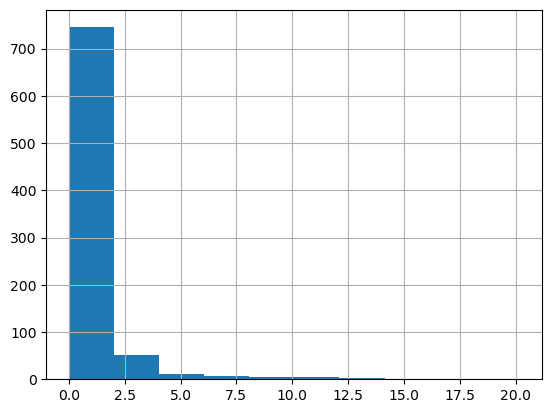

In [25]:
y.hist()

In [51]:
import joblib

joblib.dump(rf_clf, 'rf_clf.joblib', compress=True)

['rf_clf.joblib']

### Model evaluation

In [127]:
def evaluate_linear_model(model, X_train, y_train, X_test, y_test):
    # Fit the model and make predictions
    y_pred = model.fit(X_train, y_train).predict(X_test)
    y_pred[y_pred < 0] = 0
    
    # Calculate metrics
    mae = metrics.mean_absolute_error(y_test, y_pred)
    rmse = metrics.mean_squared_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    
    # Print metrics
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')
    print(f'R-squared Score: {r2:.2f}')
    
    # Scatter plot of actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.show()
    
    # Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    return y_pred, mae, rmse, r2

In [70]:
np.histogram(y_test)

(array([145,   8,   6,   2,   0,   0,   2,   0,   2,   1]),
 array([ 0.        ,  1.19126304,  2.38252608,  3.57378912,  4.76505216,
         5.9563152 ,  7.14757824,  8.33884127,  9.53010431, 10.72136735,
        11.91263039]))

Mean Absolute Error: 0.60
Root Mean Squared Error: 2.39
R-squared Score: 0.26


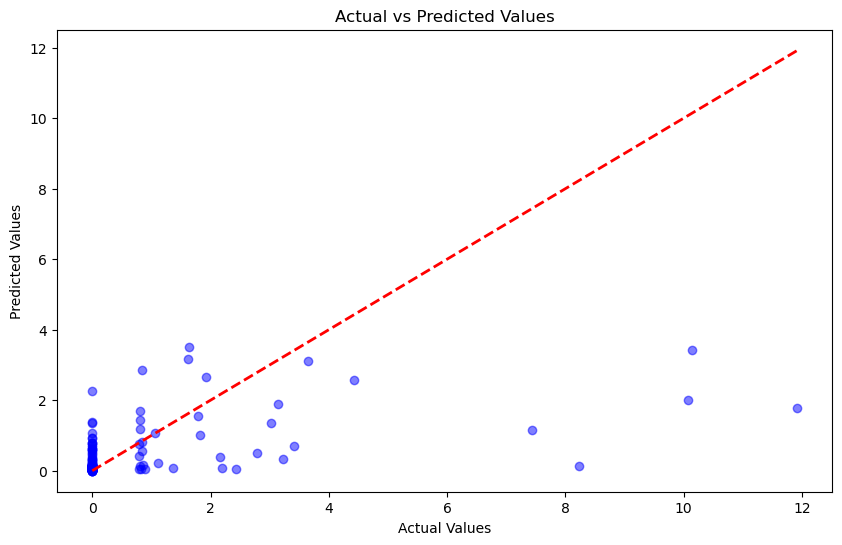

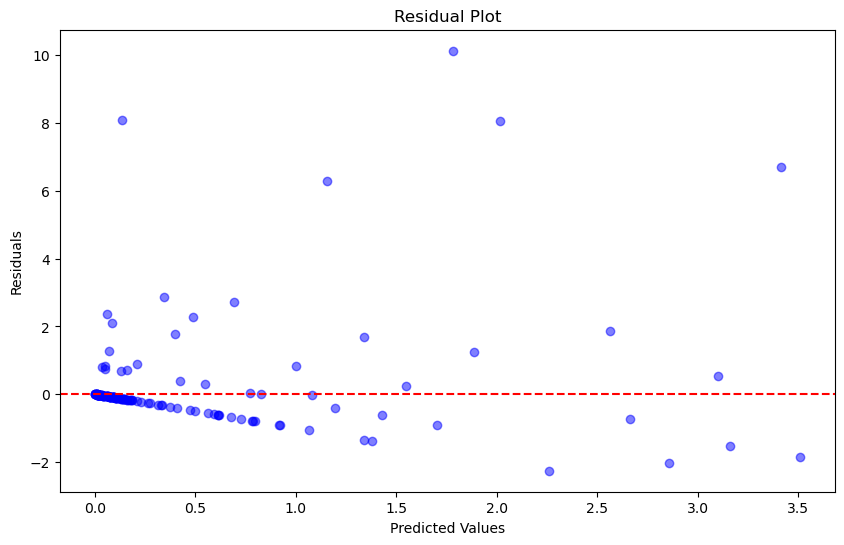

In [71]:
y_pred, mae, rmse, r2 = evaluate_linear_model(rf_clf , X_train, y_train, X_test, y_test)

### Feature importance

In [72]:
# Custom function to color rows based on RGB values
# Check if RGB value is present and is a string
def color_rows(row):
    if pd.notna(row['RGB']) and isinstance(row['RGB'], str):
        # Convert RGB string to CSS-compatible format
        rgb = row['RGB'].replace('-', ',')
        background_color = f'background-color: rgb({rgb})'
    else:
        # Default color for missing RGB values
      background_color = 'background-color: white'
    # Set text color to gray
    text_color = 'color: gray'
    
    return [f'{background_color}; {text_color}'] * len(row)

In [73]:
clc_legend.style \
 .format(precision=0, thousands=".", decimal=",") \
 .apply(color_rows, axis=1)

,GRID_CODE,CLC_CODE,LABEL1,LABEL2,LABEL3,RGB,Label_concat
0,1,111,Artificial surfaces,Urban fabric,Continuous urban fabric,230-000-077,Artificial surfaces - Urban fabric - Continuous urban fabric
1,2,112,Artificial surfaces,Urban fabric,Discontinuous urban fabric,255-000-000,Artificial surfaces - Urban fabric - Discontinuous urban fabric
2,3,121,Artificial surfaces,"Industrial, commercial and transport units",Industrial or commercial units,204-077-242,"Artificial surfaces - Industrial, commercial and transport units - Industrial or commercial units"
3,4,122,Artificial surfaces,"Industrial, commercial and transport units",Road and rail networks and associated land,204-000-000,"Artificial surfaces - Industrial, commercial and transport units - Road and rail networks and associated land"
4,5,123,Artificial surfaces,"Industrial, commercial and transport units",Port areas,230-204-204,"Artificial surfaces - Industrial, commercial and transport units - Port areas"
5,6,124,Artificial surfaces,"Industrial, commercial and transport units",Airports,230-204-230,"Artificial surfaces - Industrial, commercial and transport units - Airports"
6,7,131,Artificial surfaces,"Mine, dump and construction sites",Mineral extraction sites,166-000-204,"Artificial surfaces - Mine, dump and construction sites - Mineral extraction sites"
7,8,132,Artificial surfaces,"Mine, dump and construction sites",Dump sites,166-077-000,"Artificial surfaces - Mine, dump and construction sites - Dump sites"
8,9,133,Artificial surfaces,"Mine, dump and construction sites",Construction sites,255-077-255,"Artificial surfaces - Mine, dump and construction sites - Construction sites"
9,10,141,Artificial surfaces,"Artificial, non-agricultural vegetated areas",Green urban areas,255-166-255,"Artificial surfaces - Artificial, non-agricultural vegetated areas - Green urban areas"


In [74]:
clc_legend = clc_legend.dropna()

In [75]:
clc_legend['Label_concat'] = clc_legend['LABEL1'] + ' - ' + clc_legend['LABEL2'] + ' - ' + clc_legend['LABEL3']
#clc_legend['Label_concat'] = clc_legend['Label_concat'].map(lambda x : str(x).replace(' ', '_'))

In [76]:
clc_codes = clc_legend[['CLC_CODE', 'Label_concat']].to_dict(orient='records')
merged_dict = {k: v for d in clc_codes for k, v in d.items()}

In [77]:
merged_dict = dict()

for d in clc_codes:
    merged_dict['Class_' + str(int(d['CLC_CODE']))] = d['Label_concat']

In [78]:
merged_dict

{'Class_111': 'Artificial surfaces - Urban fabric - Continuous urban fabric',
 'Class_112': 'Artificial surfaces - Urban fabric - Discontinuous urban fabric',
 'Class_121': 'Artificial surfaces - Industrial, commercial and transport units - Industrial or commercial units',
 'Class_122': 'Artificial surfaces - Industrial, commercial and transport units - Road and rail networks and associated land',
 'Class_123': 'Artificial surfaces - Industrial, commercial and transport units - Port areas',
 'Class_124': 'Artificial surfaces - Industrial, commercial and transport units - Airports',
 'Class_131': 'Artificial surfaces - Mine, dump and construction sites - Mineral extraction sites',
 'Class_132': 'Artificial surfaces - Mine, dump and construction sites - Dump sites',
 'Class_133': 'Artificial surfaces - Mine, dump and construction sites - Construction sites',
 'Class_141': 'Artificial surfaces - Artificial, non-agricultural vegetated areas - Green urban areas',
 'Class_142': 'Artificial s

In [79]:
cols_complete = ['Class_' + merged_dict[col] if col in merged_dict else col for col in cols ]

In [80]:
df_importance = pd.DataFrame({'features' : cols_complete, 'importance': rf_clf.feature_importances_}).sort_values('importance', ascending=False)

<Axes: >

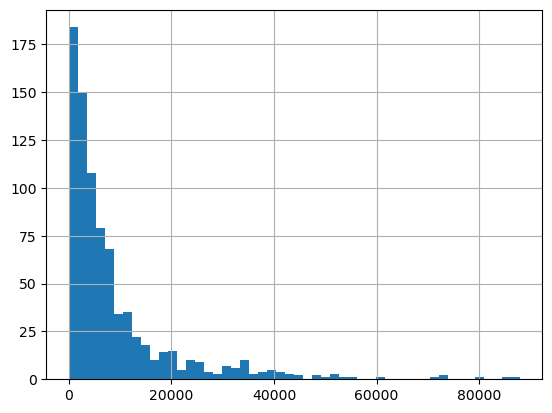

In [142]:
X['Route empierrée'].hist(bins=50)

In [81]:
df_importance

,features,importance
11,Class_Forest and semi natural areas - Forests - Coniferous forest,2.117783e-01
31,Route empierrée,8.930623e-02
7,Class_Forest and semi natural areas - Forests - Mixed forest,6.520068e-02
32,Route à 1 chaussée,6.358695e-02
3,Class_Agricultural areas - Arable land - Non-irrigated arable land,6.102586e-02
24,MNT,5.758437e-02
34,Sentier,5.034823e-02
25,slope,4.789933e-02
30,Chemin,4.405301e-02
27,P21_POP,4.102292e-02


In [82]:
com_wildfires.iloc[360]

ID                                                                                                            COMMUNE_0000000009747290
NOM                                                                                                                         Saint-Just
NOM_M                                                                                                                       SAINT-JUST
INSEE_COM                                                                                                                        18218
STATUT                                                                                                                  Commune simple
POPULATION                                                                                                                         650
INSEE_CAN                                                                                                                           17
INSEE_ARR                                              

In [88]:
df_ml_score[target].mean()

0.6460906688490918

In [89]:
y_pred.max()

3.505923875813664

# Shap values

In [90]:
import shap

In [91]:
shap.initjs()

In [92]:
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_test[cols])

/Users/audreyhohmann/miniconda3/envs/geoproject2/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


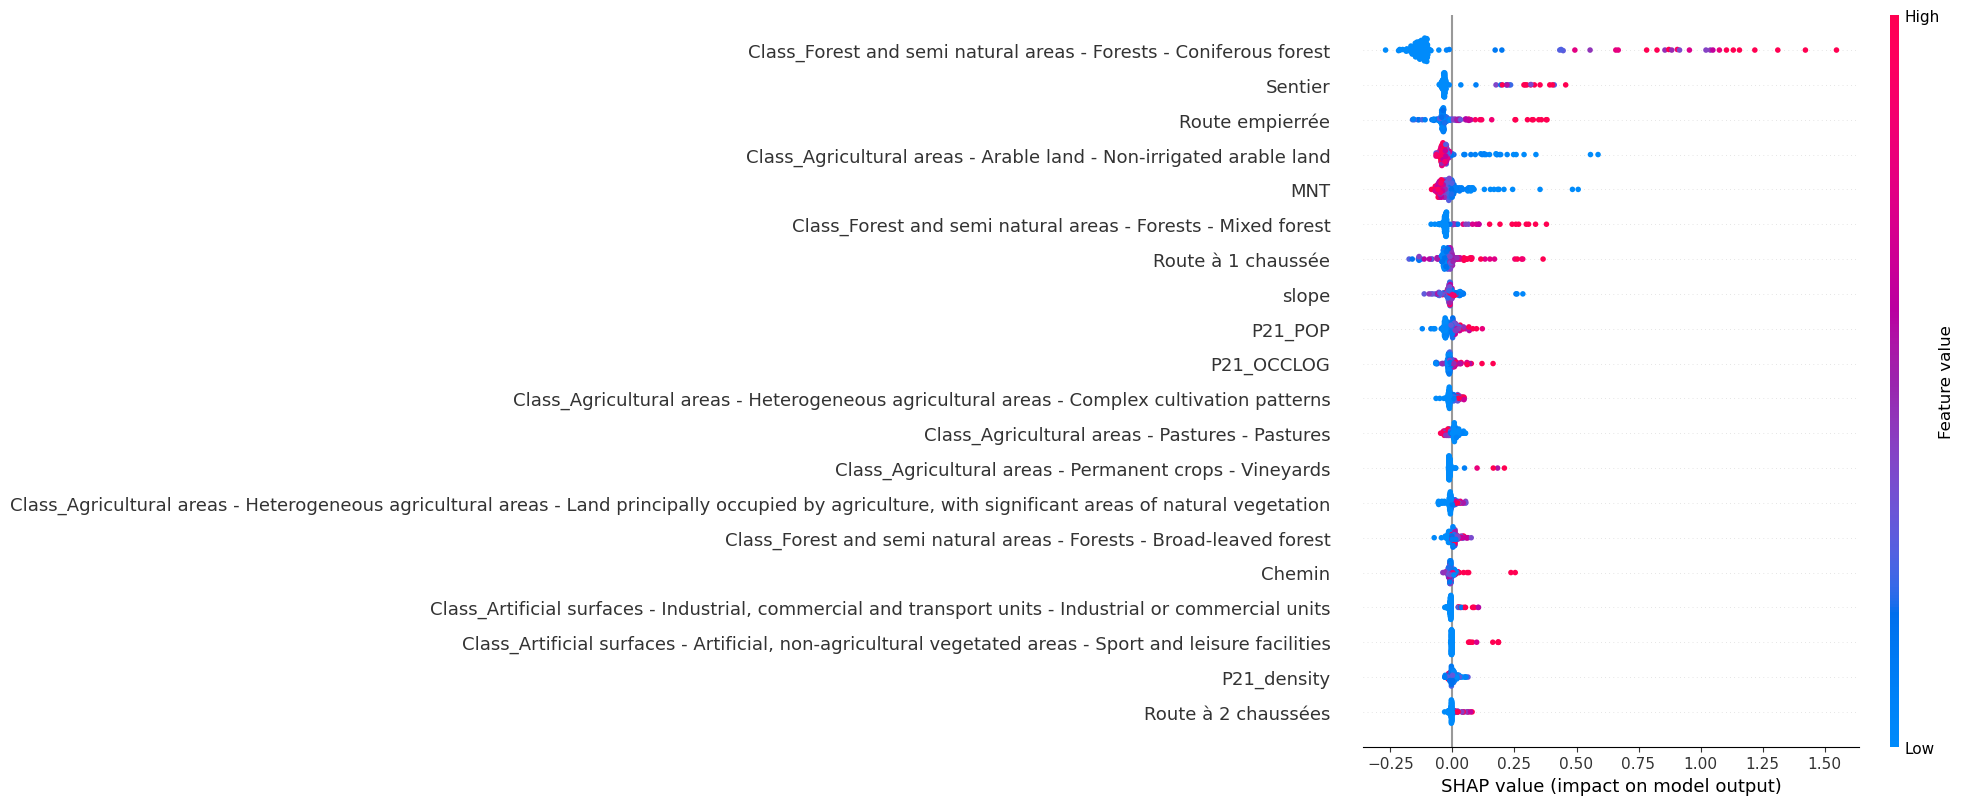

In [93]:
shap.summary_plot(shap_values, X_test[cols], feature_names=cols_complete)

/Users/audreyhohmann/miniconda3/envs/geoproject2/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


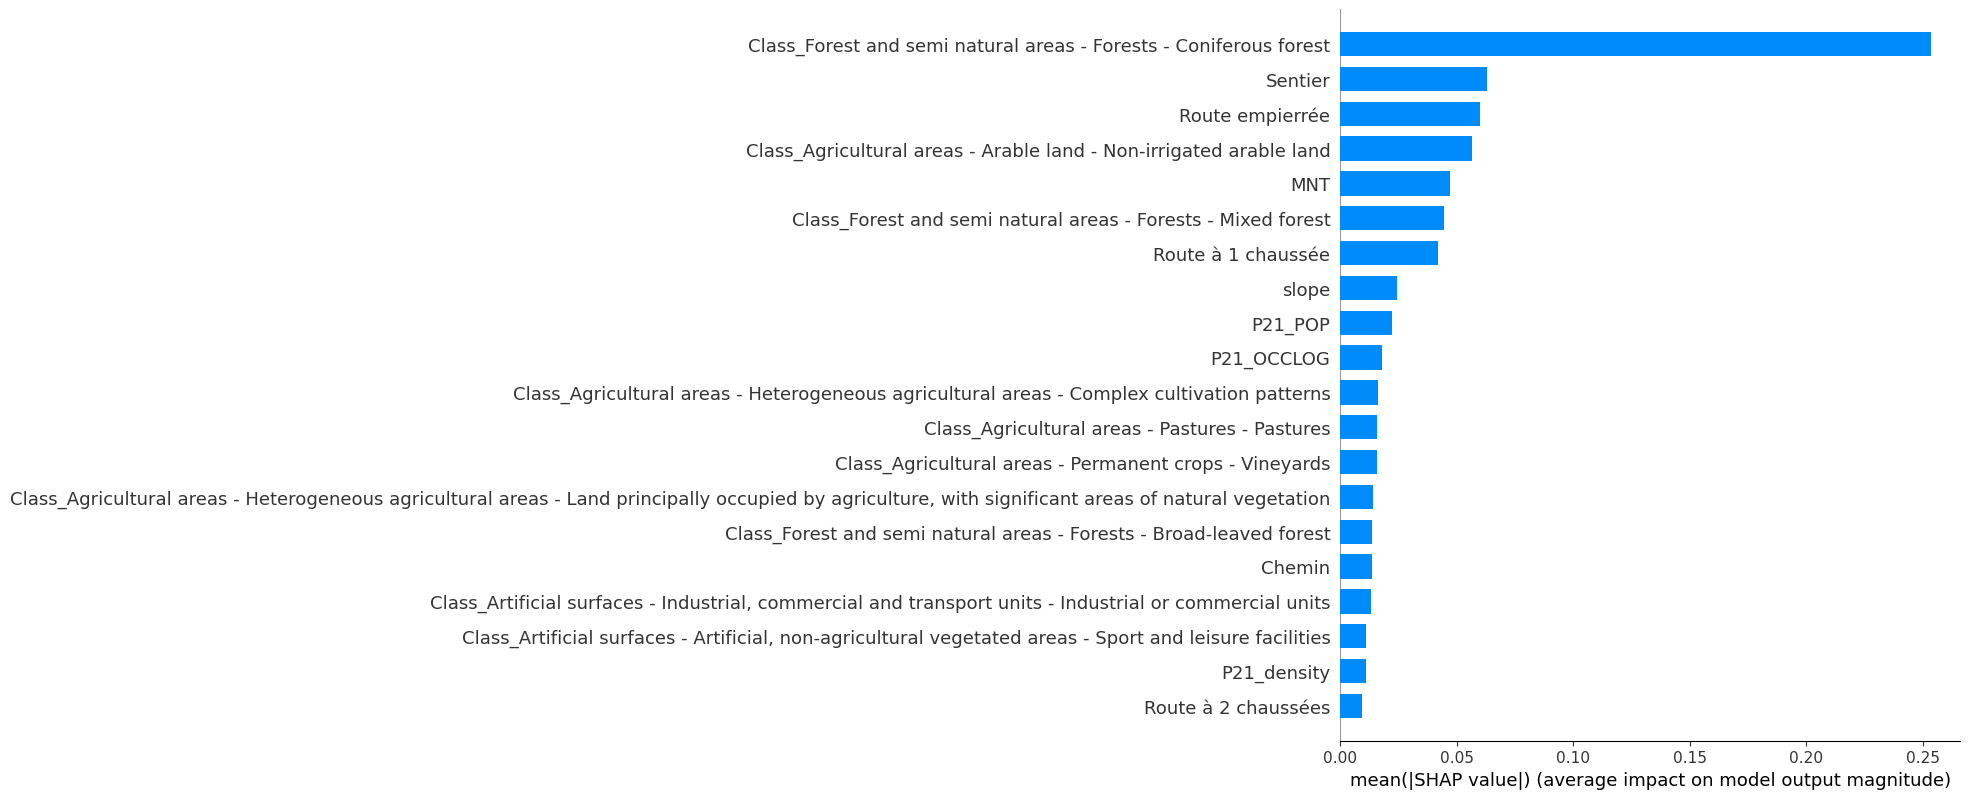

In [94]:
shap.summary_plot(shap_values, X_test[cols], plot_type="bar",  feature_names=cols_complete)

In [95]:
ind = 125

In [96]:
y_test.iloc[ind]

0.0

In [97]:
y_pred[ind]

1.3408326332987863

In [98]:
shap.force_plot(explainer.expected_value, shap_values[ind, :], X_test[cols].iloc[ind, :])

In [99]:
shap_values[ind, 11]

1.1043710440794867

In [100]:
df_shape_one_prediction = pd.DataFrame({'feature': cols_complete, 'shap_value': shap_values[ind, :]})

In [101]:
sum_shap_values = np.sum(np.abs(shap_values[ind, :]))

In [102]:
sum_shap_values

2.1191344313342535

In [103]:
df_shape_one_prediction['shap_proportion'] = df_shape_one_prediction['shap_value'] / sum_shap_values

In [104]:
df_shape_one_prediction.sort_values('shap_value', ascending=False).head(5)

,feature,shap_value,shap_proportion
11,Class_Forest and semi natural areas - Forests - Coniferous forest,1.104371,0.521143
3,Class_Agricultural areas - Arable land - Non-irrigated arable land,0.114150,0.053866
31,Route empierrée,0.110998,0.052379
27,P21_POP,0.067943,0.032062
28,P21_OCCLOG,0.057962,0.027352


# Extract data and model

In [111]:
X_test.to_parquet('X_test.parquet')